<a href="https://colab.research.google.com/github/hekmat-ashqer/MLJourney2024/blob/main/Parkinsons_Speech_Analysis/Parkinsons_Speech_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ParkDetect: Speech Pattern Analysis for Parkinson's Disease Detection

By Hikmat Ashqar

30/3/2024


<p>We will be using the <a href="https://www.kaggle.com/datasets/dipayanbiswas/parkinsons-disease-speech-signal-features" target="_blank">Parkinson's Disease classification dataset from Kaggle</a>.</p>



<p>The goal of this prediction is to classify if a patient's speech patterns are indicative of having Parkinson's (class=1) or healthy/no-parkinsons (class=0) using statistics about their speech patterns.</p>



<p><img src="https://storage.googleapis.com/kaggle-datasets-images/209295/457235/71b6b2215a1d3134503df5b5ba309748/dataset-cover.jpg?t=2019-05-29-16-55-10" referrerpolicy="no-referrer" alt="img" style="width: 460px; height: 97px; display: block; margin: auto;" width="460" height="97" title="img"></p>



<p class="text-center"><a href="https://www.kaggle.com/datasets/dipayanbiswas/parkinsons-disease-speech-signal-features" target="_blank">Image Source</a></p>



<p>According to the <a href="https://www.michaeljfox.org/news/speech-swallowing-problems#:~:text=Parkinson's%20disease%20(PD)%20can%20affect,the%20end%20of%20a%20sentence" target="_blank">Michael J. Fox Parkinson's Foundation</a>: "Parkinson's disease (PD) can affect speech in several ways. Many people with PD speak quietly and in one tone; they don't convey much emotion. Sometimes speech sounds breathy or hoarse. People with Parkinson's might slur words, mumble, or trail off at the end of a sentence. Most people talk slowly, but some speak rapidly, even stuttering or stammering."</p>



<p>There are many different statistics that have been calculated based on recordings of the patient's speech. There are 753 features in this dataset. Thankfully, there are only 756 rows, so it will still be relatively easy to work with.</p>



<p>You can grab a copy of the data from this <a href="https://www.kaggle.com/datasets/dipayanbiswas/parkinsons-disease-speech-signal-features?resource=download" target="_blank">share link</a>.



## 1. Import Libraries


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
set_config(transform_output='pandas')

## helper function for reports

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



## Data Loading & inspection

In [2]:
# Load in from Dojo folder structure
filename = '/content/drive/MyDrive/CodingDojo/02-IntroML/Week07/Data/pd_speech_features.csv'
df = pd.read_csv(filename)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [3]:
# check for null values
df.isna().sum().sum()

0

In [4]:
# Checking the unique dtypes
df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

The data is clean and entirely numeric. The only preprocessor needed is a StandardScaler.

We will drop the 'id' column since it is the specific patient's id.

In [5]:
# Create features matrix and target vector
cols_to_drop=['id']
X = df.drop(columns = [*cols_to_drop, 'class'])
y = df['class']
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [6]:
# Checking how many healthy patients vs. PD
y_train.value_counts(normalize=True)

1    0.751323
0    0.248677
Name: class, dtype: float64

We can see in the value counts of our y_train that 75% of the data is from patients with PD (class=1), and 25% is from healthy patients (class=0).

## Logistic Regression


In [7]:
# Make an instance of the model with default parameters
logreg = LogisticRegression(max_iter=500, random_state=42)
# Instantiate Standard Scaler because scaling is required for logistic regression
scaler = StandardScaler()
# Put scaler and model in a pipeline
logreg_pipe = make_pipeline(scaler, logreg)
# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       141
           1       1.00      1.00      1.00       426

    accuracy                           1.00       567
   macro avg       1.00      1.00      1.00       567
weighted avg       1.00      1.00      1.00       567



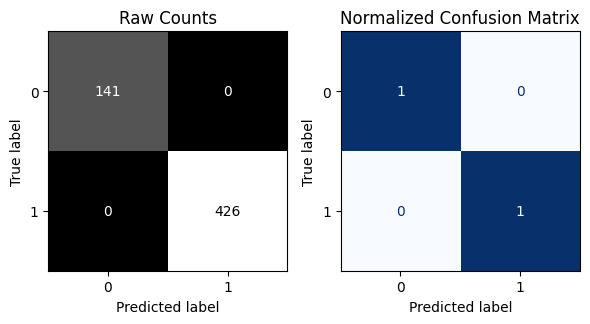


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.53      0.61        51
           1       0.84      0.92      0.88       138

    accuracy                           0.81       189
   macro avg       0.78      0.72      0.74       189
weighted avg       0.81      0.81      0.81       189



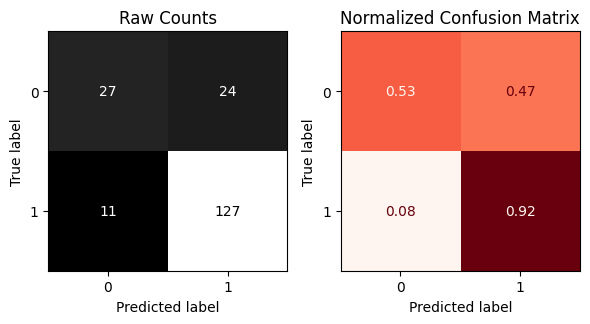

In [10]:
# Evaluate the default model
evaluate_classification(logreg_pipe, X_train, y_train, X_test, y_test)

## L1 Tuning


Let's see if we can improve the recall score for healthy patients (label=0) by tuning the value of C with GridSearchCV. We want to do so in a way that will also try to keep the recall score high for PD patients. To do so, we need to discuss which metric GridSearchCV optimizes.

We will use GridSearchCV to test different values of C with L1 regularization (penalty='l1').



In [11]:
# Create the logreg pipe with L1 regularization
logreg_pipe = make_pipeline(scaler, LogisticRegression(penalty='l1',
                                                       random_state=42,
                                                       max_iter=500))
logreg_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression',
   LogisticRegression(max_iter=500, penalty='l1', random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(max_iter=500, penalty='l1', random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 500,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': 42,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [15]:
# Remaking the model with solver='liblinear'
logreg_pipe = make_pipeline(scaler, LogisticRegression(solver='liblinear',
                                                       max_iter=500,
                                                       penalty='l1',
                                                       random_state=42))
# Define the param grid
params={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# Create the GridSearchCV object with required args
gs = GridSearchCV(logreg_pipe, params, verbose=True, n_jobs=-1,
                  return_train_score=True,scoring='recall_macro')
# Fit the gridsearch and display best params
gs.fit(X_train, y_train)
print(f'Best Params: {gs.best_params_}')




Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'logisticregression__C': 100}


In [16]:
# Making a dataframe with cv_results_
cv_results = pd.DataFrame(gs.cv_results_)
# Save the train/test scores + value for C
scores = cv_results[['param_logisticregression__C','mean_train_score','mean_test_score']]
scores = scores.set_index('param_logisticregression__C')
scores

,mean_train_score,mean_test_score
param_logisticregression__C,,
0.0001,0.500000,0.500000
0.0010,0.500000,0.500000
0.0100,0.500000,0.500000
0.1000,0.817432,0.725964
1.0000,1.000000,0.765407
10.0000,1.000000,0.764191
100.0000,1.000000,0.777356
1000.0000,1.000000,0.771597


param_logisticregression__C
0.0001       0.500000
0.0010       0.500000
0.0100       0.500000
0.1000       0.725964
1.0000       0.765407
10.0000      0.764191
100.0000     0.777356
1000.0000    0.771597
Name: mean_test_score, dtype: float64


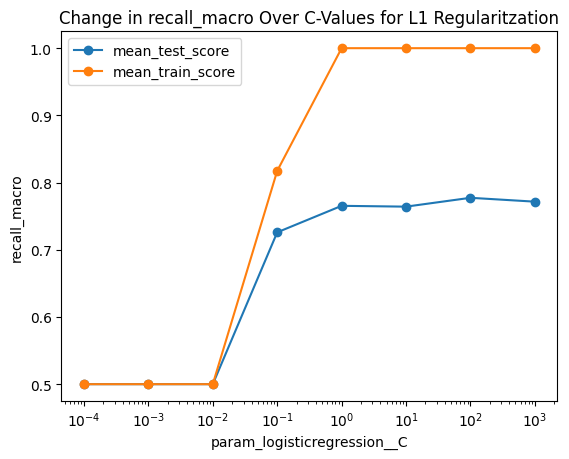

In [17]:
## Plot the training vs test scores vs. C
ax = scores.plot(y=['mean_test_score','mean_train_score'],
            style='o-',logx=True)
ax.set(ylabel=gs.scoring,
       title=f'Change in {gs.scoring} Over C-Values for L1 Regularitzation')
print(scores['mean_test_score'])

According to this graph, we get the best recall on the test set when C=100.0 (10^2)


## L2 Tuning


In [19]:
# Making a logreg pipe that uses L2 regularization
logreg_pipe = make_pipeline(scaler, LogisticRegression(solver='liblinear',
                                                       max_iter=500,
                                                       penalty='l2',
                                                       random_state=42))
# Define the params and instantiate gridsearch
params={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
gs = GridSearchCV(logreg_pipe, params,verbose=True, n_jobs=-1,
                  return_train_score=True,scoring='recall_macro')
# Fit gridsearch and display best params
gs.fit(X_train, y_train)
gs.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'logisticregression__C': 0.1}

In [21]:
# We will be reproducing thie plot many times, so let's turn it into a short-term function
def plot_cv_results(gs, param_name='param_logisticregression__C', logx = True):
    # Making a dataframe with cv_results_
  cv_results = pd.DataFrame(gs.cv_results_)
  # Save the train/test scores with values for C
  scores = cv_results[[param_name,'mean_train_score','mean_test_score']]
  scores = scores.set_index(param_name)
  ## Plot the training vs test scores vs. C
  ax = scores.plot(y=['mean_test_score','mean_train_score'],
              style='o-',logx=logx)
  ax.set(ylabel=gs.scoring)
  print(scores['mean_test_score'])
  return ax

param_logisticregression__C
0.0001       0.715964
0.0010       0.746396
0.0100       0.763730
0.1000       0.769133
1.0000       0.765698
10.0000      0.756423
100.0000     0.756521
1000.0000    0.756369
Name: mean_test_score, dtype: float64


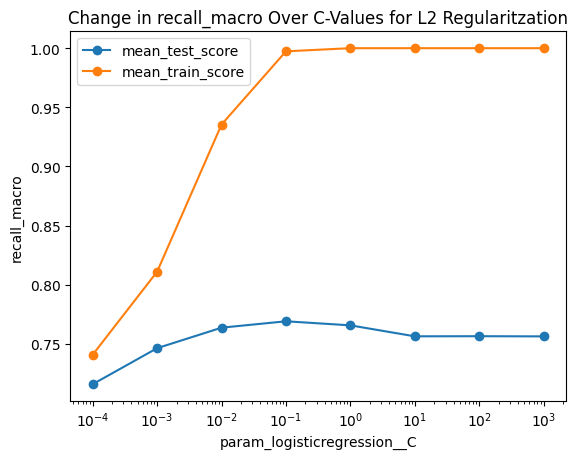

In [22]:
ax = plot_cv_results(gs)
ax.set_title(f'Change in {gs.scoring} Over C-Values for L2 Regularitzation');

With L2 regularization, we get our best score at C=1, and test scores drop off much more dramatically as C increases.

## Elasticnet Regularization


In [23]:
# Making a logreg pipe that uses elasticnet regularization
logreg_pipe = make_pipeline(scaler, LogisticRegression(solver='saga', penalty='elasticnet', max_iter=2500, random_state=42))
# Define l1_ratio params
params={
    'logisticregression__l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
# Create and fit the gridsearch and display results
gs = GridSearchCV(logreg_pipe, params,verbose=True, n_jobs=-1,cv=3,
                  return_train_score=True,scoring='recall_macro')
gs.fit(X_train, y_train)
gs.best_params_

Fitting 3 folds for each of 11 candidates, totalling 33 fits


{'logisticregression__l1_ratio': 0.1}

param_logisticregression__l1_ratio
0.0    0.780516
0.1    0.782839
0.2    0.772201
0.3    0.762736
0.4    0.762711
0.5    0.767431
0.6    0.768605
0.7    0.765058
0.8    0.765058
0.9    0.763885
1.0    0.761512
Name: mean_test_score, dtype: float64


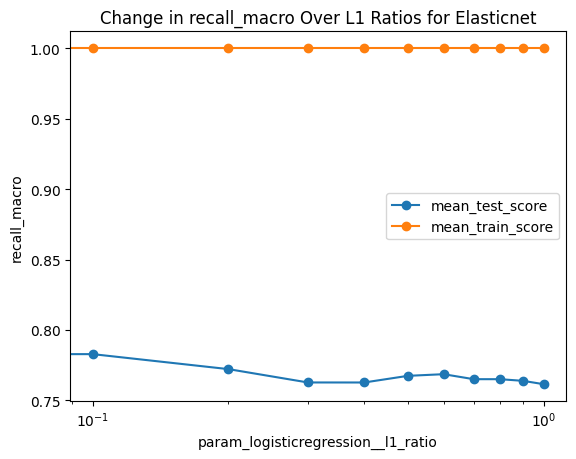

In [24]:
ax = plot_cv_results(gs, param_name='param_logisticregression__l1_ratio')
ax.set_title(f'Change in {gs.scoring} Over L1 Ratios for Elasticnet');

We see that the best recall occurs when the l1-ratio is 0.1.

# Best Params Model

## GridSearchCV with Incompatible Hyperparameters


In [25]:
# Making a starter logreg pipeline
logreg_pipe = make_pipeline(scaler, LogisticRegression(max_iter=1000,
                                                       random_state=42))

In [26]:
# Params compatible with penality='elasticnet'
elasticnet_params = {'logisticregression__solver' : ['saga'],
               'logisticregression__penalty' : ['elasticnet'],
                'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4,
                                                 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
# Params compatible with penality='l2'
l2_params = {'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                            'newton-cholesky', 'sag', 'saga'],
                  'logisticregression__penalty' : ['l2'],
                  'logisticregression__C': [0.0001, 0.001, 0.01, 0.1,
                                            1, 10, 100, 1000] }
# Params compatible with penality='l1'
l1_params = {'logisticregression__solver' : ['liblinear', 'saga'],
               'logisticregression__penalty' : ['l1'],
                'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                          10, 100, 1000]}
# Params with no penality
none_params = {'logisticregression__solver' : ['lbfgs', 'newton-cg',
                                               'newton-cholesky', 'sag', 'saga'],
               'logisticregression__penalty' : [None]}
# Now make a list of the param dictionaries
param_grid = [l2_params, l1_params, elasticnet_params, none_params]

In [27]:
## Warning: this gridsearch may take 5-10 minutes to run!!
# Instantiate gridsearch
gs = GridSearchCV(logreg_pipe, param_grid, verbose = 5, n_jobs = -1,
                  scoring='recall_macro')
# Fit the gs on the training data only
gs.fit(X_train, y_train)
gs.best_params_


Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'logisticregression__l1_ratio': 0.1,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__solver': 'saga'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       141
           1       1.00      1.00      1.00       426

    accuracy                           1.00       567
   macro avg       1.00      1.00      1.00       567
weighted avg       1.00      1.00      1.00       567



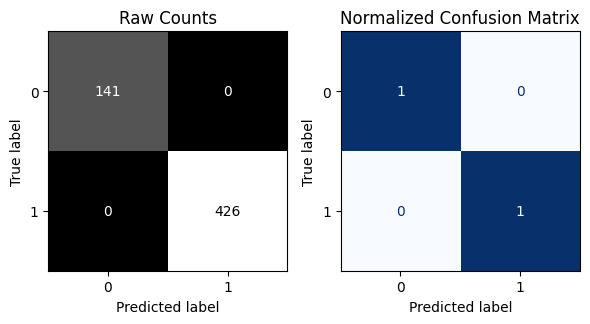


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        51
           1       0.88      0.91      0.90       138

    accuracy                           0.85       189
   macro avg       0.81      0.79      0.80       189
weighted avg       0.84      0.85      0.84       189



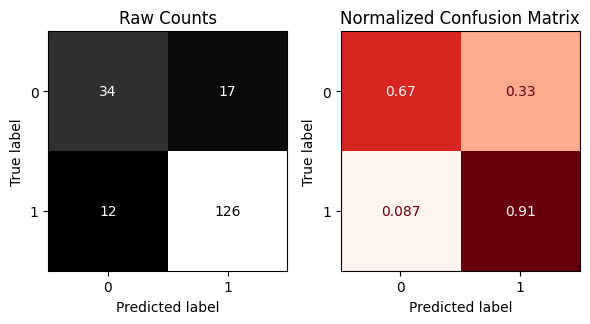

In [28]:
# Evalaute the best model
best_logreg = gs.best_estimator_
evaluate_classification(best_logreg, X_train, y_train, X_test, y_test)


Our best model, with a recall macro avg of .79, found our best hyperparameter settings for our logistic regression model would be solver='saga', penalty='elasticnet,' and l1_ratio=0.1. An l1 ratio of .1 means that the model used a combination of l1 and l2 regularization.

We improved the recall for healthy patients from 0.53 to 0.67! We did have to accept a small decrease in our recall for PD patients, however, which decreased from 0.92 to 0.91. Overall, our model has improved significantly.

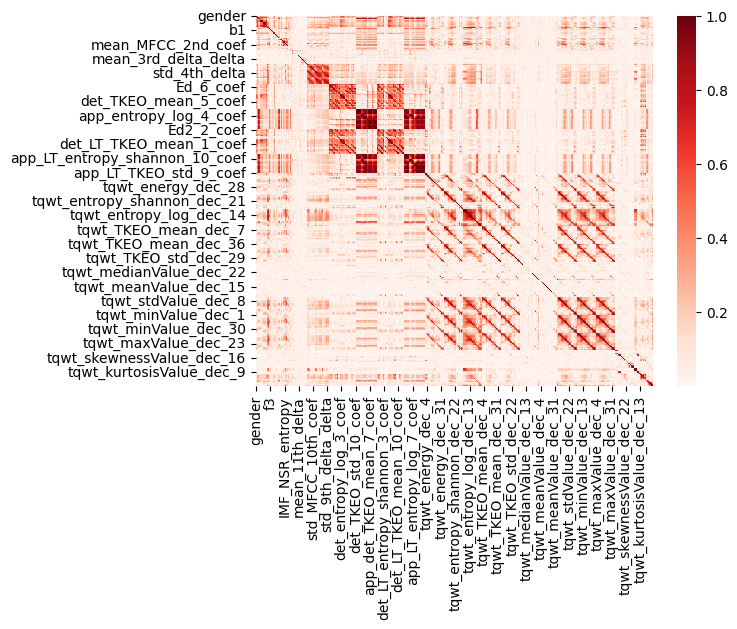

In [29]:
# Getting the absolute values of correlation matrix
X_train_corr = X_train.corr().abs()
sns.heatmap(X_train_corr, cmap='Reds');

Since there is both a large number of features as well as highly correlated features, it makes sense that the GridSearch identified elasticnet as the best penalty.